Special mention: Adopted from SP23 Recitation 0L, by Vedant Bhasin

# Using MLP: MNIST classification
Stretching on the recitation 0L, we will explore MNIST classification using MLP in this notebook. Most of the contents are adopted from Recitation 0L notebook, but this recitation will focus more on the MLP model implementation part.

We're going to use the MNIST dataset which consists of handwritten digits 0-9 and use a neural network, specifically MLP, to classify them.

In [1]:
!pip install -q torchsummaryX

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchsummaryX import summary
import sklearn
import sklearn.metrics
from tqdm.auto import tqdm
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cpu


## Understanding MNIST data
Data loading & Processing details could be found in Recitation 0L. Below, we display the loaded data which the features are of shape B x 1 x 28 x 28 where B is batch size, '1' is channel size (grayscale image), and the labels are of shape B. This means that we have 'B' 1 x 28 x 28 images. Since we're using an MLP we will have to flatten the images so our data is of shape B x 784.

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./train/MNIST/raw/train-images-idx3-ubyte.gz to ./train/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./train/MNIST/raw/train-labels-idx1-ubyte.gz to ./train/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./train/MNIST/raw/t10k-images-idx3-ubyte.gz to ./train/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./train/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./train/MNIST/raw



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./test/MNIST/raw/train-images-idx3-ubyte.gz to ./test/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./test/MNIST/raw/train-labels-idx1-ubyte.gz to ./test/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./test/MNIST/raw/t10k-images-idx3-ubyte.gz to ./test/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./test/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./test/MNIST/raw



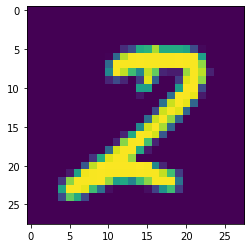

2




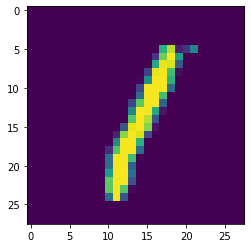

1




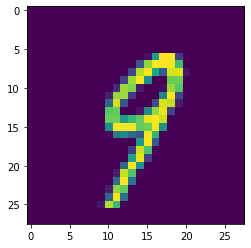

9




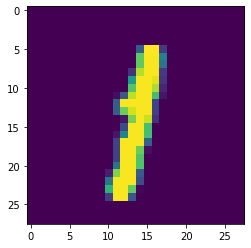

1




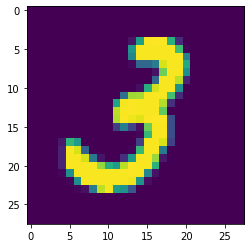

3




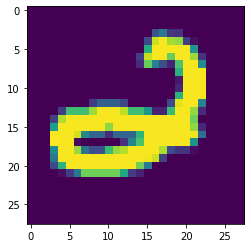

2


data shape: torch.Size([64, 1, 28, 28])
label shape: torch.Size([64])


In [ ]:
transform = torchvision.transforms.ToTensor()
train_dataset = torchvision.datasets.MNIST('./train', download=True, train=True, transform=transform)

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.8,0.2])
test_dataset = torchvision.datasets.MNIST('./test', download=True, train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader  = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

import matplotlib.pyplot as plt
import numpy as np


for i, data in enumerate(train_loader):
  x, y = data
  img, label = x[0, :, :, :], y[0].item()
  
  npimg = img.numpy()
  # plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.imshow(npimg.squeeze())
  plt.show()
  print(label)
  print('\n')
  if i == 5:
    print(f'data shape: {x.shape}')
    print(f'label shape: {y.shape}')
    break

## Declaring MLP Models

Before setting up training, we must declare the model that we would like to use for this classification task. When building MLP models, you can decide on the architecture by differing the number of hidden layers, sizes of each layer, activation functions that you would like to use, and the list goes on. Since finding out which architecture works the best is the main task that you'd be working on during HW1, we only show two simple examples of MLP models below.

Note that while we could differ the size of the hidden layer, ```IN_SIZE``` and ```OUT_SIZE``` are fixed to ```28*28``` and ```10``` since we are always passing in 784 linear features and would like to classify among 10 possible labels.

### Example 1

One hidden layer neural network with ReLU activation

In [ ]:
IN_SIZE = 28*28
HIDDEN_SIZE = 1024
OUT_SIZE = 10

model_1 = torch.nn.Sequential(
                          torch.nn.Linear(IN_SIZE, HIDDEN_SIZE),
                          torch.nn.ReLU(),
                          torch.nn.Linear(HIDDEN_SIZE, OUT_SIZE)
)
summary(model_1, data[0].flatten(start_dim=1))

      Kernel Shape Output Shape   Params Mult-Adds
Layer                                             
0_0    [784, 1024]   [64, 1024]  803.84k  802.816k
1_1              -   [64, 1024]        -         -
2_2     [1024, 10]     [64, 10]   10.25k    10.24k
----------------------------------------------------
                        Totals
Total params           814.09k
Trainable params       814.09k
Non-trainable params       0.0
Mult-Adds             813.056k


/usr/local/lib/python3.8/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_0,"[784, 1024]","[64, 1024]",803840.0,802816.0
1_1,-,"[64, 1024]",NaN,NaN
2_2,"[1024, 10]","[64, 10]",10250.0,10240.0


### Example 2

Three hidden layers that are hourglass-shaped with LeakyReLU activation

Note: You can explore different shapes that hidden layers could take, such as cylindrical, hoursglass, pyramid, and so on. (More details to be shared when HW1 gets released, so stay tuned!)

In [ ]:
IN_SIZE = 28*28
HIDDEN_SIZE_1 = 2048
HIDDEN_SIZE_2 = 1024
HIDDEN_SIZE_3 = 2048
OUT_SIZE = 10

model_2 = torch.nn.Sequential(
                          torch.nn.Linear(IN_SIZE, HIDDEN_SIZE_1),
                          torch.nn.LeakyReLU(),
                          torch.nn.Linear(HIDDEN_SIZE_1, HIDDEN_SIZE_2),
                          torch.nn.LeakyReLU(),
                          torch.nn.Linear(HIDDEN_SIZE_2, HIDDEN_SIZE_3),
                          torch.nn.LeakyReLU(),
                          torch.nn.Linear(HIDDEN_SIZE_3, OUT_SIZE)
)
summary(model_2, data[0].flatten(start_dim=1))

       Kernel Shape Output Shape     Params  Mult-Adds
Layer                                                 
0_0     [784, 2048]   [64, 2048]   1.60768M  1.605632M
1_1               -   [64, 2048]          -          -
2_2    [2048, 1024]   [64, 1024]  2.098176M  2.097152M
3_3               -   [64, 1024]          -          -
4_4    [1024, 2048]   [64, 2048]    2.0992M  2.097152M
5_5               -   [64, 2048]          -          -
6_6      [2048, 10]     [64, 10]     20.49k     20.48k
------------------------------------------------------
                         Totals
Total params          5.825546M
Trainable params      5.825546M
Non-trainable params        0.0
Mult-Adds             5.820416M


/usr/local/lib/python3.8/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_0,"[784, 2048]","[64, 2048]",1607680.0,1605632.0
1_1,-,"[64, 2048]",NaN,NaN
2_2,"[2048, 1024]","[64, 1024]",2098176.0,2097152.0
3_3,-,"[64, 1024]",NaN,NaN
4_4,"[1024, 2048]","[64, 2048]",2099200.0,2097152.0
5_5,-,"[64, 2048]",NaN,NaN
6_6,"[2048, 10]","[64, 10]",20490.0,20480.0


## Training & Evaluation
Now that we have our MLP models declared, let's train and test how well our model does. For implementation details, please refer to Reciation 0L. 

To ensure fair comparison of our models, we have used the same optimizer (Adam) and loss criterion (cross-entropy loss), as well as the same number of epochs (10).

In [ ]:
def train_epoch(model, optimizer, criterion, data_loader):
    model.train()
    train_loss = 0.0

    for i, (images, labels) in enumerate(tqdm(data_loader)):
        images = images.to(device)
        labels = labels.to(device)

        model_out = model(images.flatten(start_dim=1))

        loss = criterion(model_out, labels)

        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss /= len(data_loader)
    return train_loss

In [ ]:
def eval(model, data_loader):
    model.eval()

    true_labels = []
    pred_labels = []

    for i, (images, labels) in enumerate(data_loader):
        images, labels = images.to(device), labels.to(device)

        with torch.inference_mode():
            logits = model(images.flatten(start_dim=1))

        preds = torch.argmax(logits, dim=1).squeeze()
        pred_labels.extend(preds.cpu().tolist())
        true_labels.extend(labels.cpu().tolist())
    accuracy = sklearn.metrics.accuracy_score(pred_labels, true_labels) 
    return accuracy*100

### Training Model Example 1

In [ ]:
optimizer   = torch.optim.Adam(model_1.parameters(), lr= 0.001)
criterion   = torch.nn.CrossEntropyLoss()

NUM_EPOCHS = 10

for epoch in range(NUM_EPOCHS):
    train_loss = train_epoch(model_1, optimizer, criterion, train_loader)
    val_acc    = eval(model_1, val_loader)
    print(f'train_loss: {train_loss} \tval_acc: {val_acc}')

  0%|          | 0/750 [00:00<?, ?it/s]

train_loss: 0.25174174903084834 	val_acc: 96.2


  0%|          | 0/750 [00:00<?, ?it/s]

train_loss: 0.09761320655917127 	val_acc: 97.18333333333334


  0%|          | 0/750 [00:00<?, ?it/s]

train_loss: 0.059615952419427534 	val_acc: 97.13333333333334


  0%|          | 0/750 [00:00<?, ?it/s]

train_loss: 0.040805371188248195 	val_acc: 97.75


  0%|          | 0/750 [00:00<?, ?it/s]

train_loss: 0.031217038524725165 	val_acc: 97.75833333333334


  0%|          | 0/750 [00:00<?, ?it/s]

train_loss: 0.02030571390579765 	val_acc: 97.7


  0%|          | 0/750 [00:00<?, ?it/s]

train_loss: 0.017446686274488456 	val_acc: 97.775


  0%|          | 0/750 [00:00<?, ?it/s]

train_loss: 0.014267476324147235 	val_acc: 98.05833333333334


  0%|          | 0/750 [00:00<?, ?it/s]

train_loss: 0.013220799089836267 	val_acc: 97.34166666666667


  0%|          | 0/750 [00:00<?, ?it/s]

train_loss: 0.009049470660897592 	val_acc: 98.00833333333333


### Training Model Example 2


In [ ]:
optimizer   = torch.optim.Adam(model_2.parameters(), lr= 0.001)
criterion   = torch.nn.CrossEntropyLoss()

NUM_EPOCHS = 10

for epoch in range(NUM_EPOCHS):
    train_loss = train_epoch(model_2, optimizer, criterion, train_loader)
    val_acc    = eval(model_2, val_loader)
    print(f'train_loss: {train_loss} \tval_acc: {val_acc}')

  0%|          | 0/750 [00:00<?, ?it/s]

train_loss: 0.23163311831777295 	val_acc: 95.8


  0%|          | 0/750 [00:00<?, ?it/s]

train_loss: 0.10448346374245981 	val_acc: 97.29166666666667


  0%|          | 0/750 [00:00<?, ?it/s]

train_loss: 0.07459765474816474 	val_acc: 97.45833333333334


  0%|          | 0/750 [00:00<?, ?it/s]

train_loss: 0.05808772081326848 	val_acc: 97.20833333333333


  0%|          | 0/750 [00:00<?, ?it/s]

train_loss: 0.04567856373271206 	val_acc: 97.8


  0%|          | 0/750 [00:00<?, ?it/s]

train_loss: 0.038705406951727736 	val_acc: 97.475


  0%|          | 0/750 [00:00<?, ?it/s]

train_loss: 0.03647979784549776 	val_acc: 97.3


  0%|          | 0/750 [00:00<?, ?it/s]

train_loss: 0.032323766699276654 	val_acc: 97.68333333333334


  0%|          | 0/750 [00:00<?, ?it/s]

train_loss: 0.031133724578399174 	val_acc: 97.81666666666666


  0%|          | 0/750 [00:00<?, ?it/s]

train_loss: 0.02625549966084509 	val_acc: 97.30833333333334


### Testing Both Model Examples

In [ ]:
print('Example 1 Accuracy: ', eval(model_1, test_loader))
print('Example 2 Accuracy: ', eval(model_2, test_loader))

Example 1 Accuracy:  98.00833333333333
Example 2 Accuracy:  97.30833333333334
